In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme(font_scale=1.5)
from tqdm import tqdm
from scipy.optimize import minimize
from src.QubitClass import One_qubit
from src.utils import Hamiltonian, prepare_state, get_energy, minimize_energy

# One qubit VQE

This code will compare the energy levels obtained from a Variational Quantum Eigensolver (VQE) approach against exact solutions obtained from numerical diagonalization of the Hamiltonian.

*Note: We are using the Hamiltonian function as from `StandardEigenvalueSolver.ipynb` by importing it from `utils`.*

First we use the VQE method with our own minimize funtion and the with the Scipy minimize function.

In [2]:
# VQE with tge minimizer found in utils.py
number_shots_search = 10_000
number_shots = 10_000

learning_rate = 0.3
max_epochs = 400

lmbvalues = np.linspace(0.0, 1.0, 50)
min_energy = np.zeros(len(lmbvalues))

epochs = np.zeros(len(lmbvalues))

for index, lmb in enumerate(tqdm(lmbvalues)):
    memory = 0
    angles_0 = np.random.uniform(low = 0, high = np.pi, size = 2)
    angles, epochs[index], converged, energy, delta_energy = minimize_energy(lmb, number_shots_search, angles_0, learning_rate, max_epochs)
    
    if epochs[index] < (epochs[index-1] - 5):
        angles_0 = np.random.uniform(low = 0, high = np.pi, size = 2)
        angles, epochs[index], converged, energy, delta_energy = minimize_energy(lmb, number_shots_search, angles_0, learning_rate, max_epochs)
    
    min_energy[index] = get_energy(angles, lmb, number_shots)

100%|██████████| 50/50 [00:17<00:00,  2.89it/s]


In [3]:
# VQE with scipy minimizer
number_shots = 10_000
lmbvalues_scipy = np.linspace(0.0, 1.0, 30)

min_energy_scipy = np.zeros(len(lmbvalues_scipy))

for index, lmb in enumerate(tqdm(lmbvalues_scipy)):
    angles_start = np.random.uniform(low = 0, high = np.pi, size = 4)
    res = minimize(get_energy, angles_start, args = (lmb, number_shots), method = 'Powell', options = {'maxiter': 1000}, tol = 1e-5)
    
    min_energy_scipy[index] = res.fun

  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 30/30 [00:09<00:00,  3.10it/s]


Now, we compute the energy levels of the system are computed by finding the eigenvalues of the Hamiltonian. Then we find lowest energy levels from exact diagonalization.

In [4]:
# Set up the arrays for lambda values and eigenvalues
lmbvalues_ana = np.arange(0, 1, 0.01)
eigvals_ana = np.zeros((len(lmbvalues_ana), 2))

# Loop over all lambda values and diagonalize the Hamiltonian
for index, lmb in enumerate(lmbvalues_ana):
    H = Hamiltonian(lmb)
    eigen, eigvecs = np.linalg.eig(H)
    permute = eigen.argsort()
    eigvals_ana[index] = eigen[permute]
    eigvecs = eigvecs[:,permute]

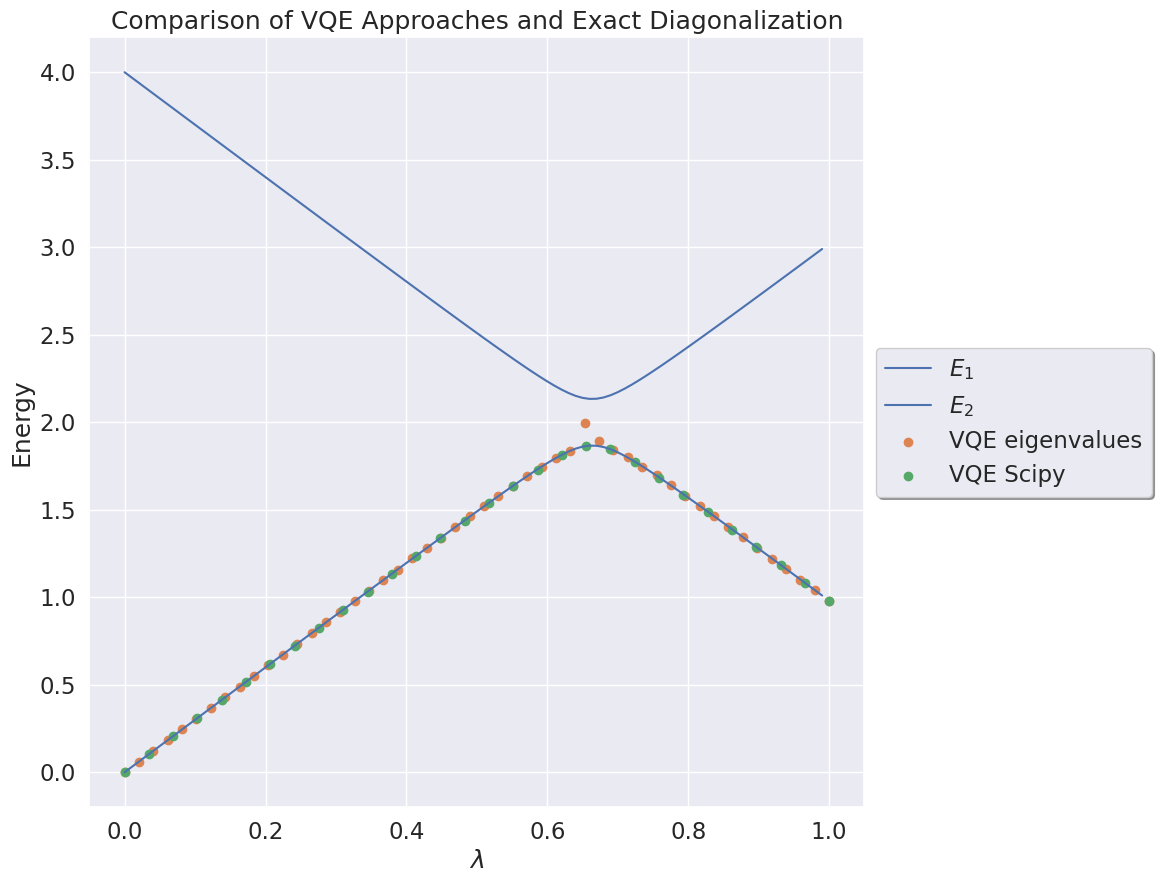

In [5]:
# Plotting the results

fig, axs = plt.subplots(1, 1, figsize=(10, 10))

for i in range(2):
    axs.plot(lmbvalues_ana, eigvals_ana[:,i], label=f'$E_{i+1}$', color = '#4c72b0')

axs.scatter(lmbvalues, min_energy, label = 'VQE eigenvalues', color = '#dd8452')
axs.scatter(lmbvalues_scipy, min_energy_scipy, label = 'VQE Scipy', color = '#55a868')
axs.set_xlabel(r'$\lambda$')
axs.set_ylabel('Energy')

axs.legend(loc='center left', bbox_to_anchor=(1, 0.5),
          fancybox=True, shadow=True, ncol=1)
plt.title('Comparison of VQE Approaches and Exact Diagonalization')
plt.show()